In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#for tensorboard adpation
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

#Additional Imports
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools as it
import datetime
import cv2 as cv
import os
import glob


#HPO
import optuna

#User defined we have set our own UNET, MultiInput_Unet,Unet_Dataset and MI_Dataset
from neural_networks import UNET, MultiInput_UNET
from data_set import UNET_Dataset, MI_Dataset

In [2]:
#Hier we test Unet_Model and MultipleUnet_Model and predicted images are saved for presentation

### to make the shape of image is 256*256,because the channel is 4 dimensions , for displaying the depth image the dimension needs to be 2 
def convert_to_image( y_pred, y_true, images, y_noisy = 0):
    rgb = []#to save list of rgb image
    bad = []#to save list of depth_bad image
    pred = []#to save list of predicted image
    true = []#to save list of depth_real image
    i = 0
    for y in y_pred:
        pred.append(y.cpu().detach().numpy().transpose((2,3,1,0)).reshape(256,256))
    for y in y_true:
        true.append(y.cpu().detach().numpy().transpose((2,3,1,0)).reshape(256,256))
    if len(images[0][0,:,0,0]) == 3:
        #MultiInputNet
        for img in images:
            rgb.append(img.cpu().detach().numpy().transpose((2,3,1,0)).reshape(256,256,3))
        for y in y_noisy:
            bad.append(y.cpu().detach().numpy().transpose((2,3,1,0)).reshape(128,128,3))
    else:
        #UNET
        for img in images:
            rgb.append(img.cpu().detach().numpy().transpose((2,3,1,0)).reshape(256,256,4)[:,:,0:3])
            bad.append(img.cpu().detach().numpy().transpose((2,3,1,0)).reshape(256,256,4)[:,:,3])   
    return rgb, bad, pred, true

def save_trained_images(rgb, y_bad, y_pred, y_true, directory): #to save the images in a file
    
    for idx in range(len(rgb)):
        plt.subplot(221), plt.imshow(rgb[idx])
        plt.subplot(222), plt.imshow(y_bad[idx],'gray')
        plt.subplot(223), plt.imshow(y_pred[idx],'gray')
        plt.subplot(224), plt.imshow(y_true[idx],'gray')
        plt.savefig(directory + 'img_{}'.format(idx) )


In [3]:
#HPO analyse
## use best trial we can record the best loss value
def get_best_trials(df, num_trials=1, by="value", ascending=True, split=False):## we have 174 trials, this function is to return the best trial for using it in HPO later
   
    sorted_trials = df.sort_values(by=by, ascending=ascending)
    
    if split:
        return sorted_trials[:num_trials], sorted_trials[num_trials:]
    return sorted_trials[:num_trials]

#Be sure to split your data into completed tasks and pruned tasks
def get_configs(df, param_start="params_", get_only_best=True):## to set the initial value of some parameters, such as batch_size , learning_rate and so on
   
    if get_only_best:
        df = get_best_trials(df, split=False)
        
    configs=[]
    
    #Get all config values
    params = [key for key in df.keys() if param_start in key]
    
    #Generate Dictionary with param values
    for idx, row in df.iterrows():
        config={param[len(param_start):] : row[param] for param in params}
        configs.append(config)
    
    return configs

In [4]:
#training function for unet model
##output: epoch loss

def train_HPO_unet(model, dataloader, criterion, optimizer, device):## model is unet, dataloder is for dataset, using data_dir, optimizer is adam optimizer and device is gpu
    
    epoch_loss = 0.0
    
    #Sets the Model on Training State
    model.train()
    
    #Start Trianing
    #for X, y_true in dataloader:
    for X, y_true in dataloader:
        model.zero_grad()

        X = torch.autograd.Variable(X.float())        
        y_true = torch.autograd.Variable(y_true)
        
        #Pack the Values onto the GPU or CPU
        X, y_true = X.to(device), y_true.to(device)

        #Predict Value
        y_pred = model(X.float())
        y_pred = y_pred.to(device)
        
        #Calculate loss
        batch_loss=criterion(y_pred.double(),y_true.double())
        epoch_loss += batch_loss.item() /len(dataloader)

        #Backpropagate and Optimize
        batch_loss.backward()
        optimizer.step()
        
        #Free gpu memory
        del X, y_true, y_pred
        torch.cuda.empty_cache()
    return epoch_loss

#Validation function for unet mode
##output:evaluation loss
def val_HPO_unet(model, dataloader, criterion, device):##to get the best hp for unet network
   
    #VALIDATION
    model.eval()
    eval_loss = 0.0
    with torch.no_grad(): #In this Context -> No Adjustment of gradients
        #for X, y_true in dataloader:
        for X, y_true in dataloader:
            
            X = torch.autograd.Variable(X.float())
            y_true = torch.autograd.Variable(y_true)
            
            #Pack the Values onto the GPU or CPU
            X, y_true = X.to(device), y_true.to(device)
            
            #Predict Value
            y_pred = model(X.float())
            y_pred = y_pred.to(device)
            
            eval_loss += criterion(y_pred.double(), y_true.double()).item() / len(dataloader)
            
            #Free gpu memory
            del X, y_true, y_pred
            torch.cuda.empty_cache()
    return eval_loss

In [5]:
#training function for mi model
##output: epoch loss
def train_HPO_mi(model, dataloader, criterion, optimizer, device):
    
    epoch_loss = 0.0
    
    #Sets the Model on Training State
    model.train()
    
    #Start Trianing
    #for X, y_true in dataloader:
    for X, y_bad, y_true in dataloader:
        model.zero_grad()

        X = torch.autograd.Variable(X.float())        
        y_true = torch.autograd.Variable(y_true)
        y_bad = torch.autograd.Variable(y_bad)
        
        #Pack the Values onto the GPU or CPU
        X, y_true, y_bad = X.to(device), y_true.to(device), y_bad.to(device)

        #Predict Value
        y_pred = model(X.float(), y_bad.float())
        y_pred = y_pred.to(device)
        
        #Calculate loss
        batch_loss=criterion(y_pred.double(),y_true.double())
        epoch_loss += batch_loss.item() /len(dataloader)

        #Backpropagate and Optimize
        batch_loss.backward()
        optimizer.step()
        
        #Free gpu memory
        del X, y_true, y_pred, y_bad
        torch.cuda.empty_cache()
    return epoch_loss

#val function for mi model
##output: evaluation loss
def val_HPO_mi(model, dataloader, criterion, device):
   
    #VALIDATION
    model.eval()
    eval_loss = 0.0
    with torch.no_grad(): #In this Context -> No Adjustment of gradients
        #for X, y_true in dataloader:
        for X, y_bad, y_true in dataloader:
            
            X = torch.autograd.Variable(X.float())
            y_true = torch.autograd.Variable(y_true)
            y_bad = torch.autograd.Variable(y_bad)
            
            #Pack the Values onto the GPU or CPU
            X, y_true, y_bad = X.to(device), y_true.to(device), y_bad.to(device)
            
            #Predict Value
            y_pred = model(X.float(), y_bad.float())
            y_pred = y_pred.to(device)
            
            eval_loss += criterion(y_pred.double(), y_true.double()).item() / len(dataloader)
            
            #Free gpu memory
            del X, y_true, y_pred, y_bad
            torch.cuda.empty_cache()
    return eval_loss

In [6]:
#test function for mi model
## output: rgb_image, noise_image, prediction_image, real_image
def test_mi(model, max_numb, device=torch.device("cpu")):
   
    
    test_loader = DataLoader(data_set_mi, batch_size = 1, sampler=test_sampler, drop_last=True)
    y_pred = []# to save pred_image
    y_real = []#to save real image
    img = []#to save camera image
    y_noisy = []#to save noise image
    test_loss = 0.0
    i = 0
    for image, y_bad, y_true in test_loader:
        image, y_bad, y_true = image.to(device), y_bad.to(device), y_true.to(device)
        model.to(device)
        y_pred.append(model(image.float(), y_bad.float()))
        y_real.append(y_true)
        test_loss += criterion(y_pred[-1].double(), y_true[-1].double()).item()/max_numb
        img.append(image)
        y_noisy.append(y_bad)
        i += 1
        if i == max_numb: # only predict max_numb test images
            break
    return img, y_noisy, y_pred, y_real

#test function for unet model
##output: rgb_image , prediction_image , real_ image
def test_unet(model, max_numb, device=torch.device("cpu")):
   
    test_loader = DataLoader(data_set_unet, batch_size = 1, sampler=test_sampler, drop_last=True)
    y_pred = []
    y_real = []
    y_noisy = []
    img = []
    test_loss = 0.0
    i = 0
    for image,  y_true in test_loader:
        image,  y_true = image.to(device), y_true.to(device)
        model.to(device)
        y_pred.append(model(image.float()))
        y_real.append(y_true)
        test_loss += criterion(y_pred[-1].double(), y_true[-1].double()).item()/max_numb
        img.append(image)
        i += 1
        if i == max_numb: # only predict 10 test images
            break
    return img, y_pred, y_real

In [7]:
##set the optuna configs,used to store key value pairs or some configurable information 
analyse = {
    "unet": {
    "model" : UNET,
    "study_name" : "unet_study",#create a new study_name
    "storage" : "sqlite:///HPO/optuna_db/unet_hpo.db",
    },
    "mi":{
    "model" : MultiInput_UNET,
    "study_name" : "mi_study",#create a new study_name
    "storage" : "sqlite:///HPO/optuna_db/mi_hpo.db"
    }
}

unet_configs = []#set the initial value of parameter for unet
mi_configs = []#set the initial value of parameter for mi_unet

for hpo_config in analyse.values():
    study = optuna.create_study(
        study_name=hpo_config["study_name"],
        storage=hpo_config["storage"],
        load_if_exists=True)
    
    df_c = study.trials_dataframe().loc[study.trials_dataframe()["state"]=="COMPLETE"]
    config = get_configs(df_c)
    
    if hpo_config["model"] is UNET:
        unet_configs.extend(config)
    elif hpo_config["model"] is MultiInput_UNET:
        mi_configs.extend(config)
    else:
        raise ValueError ("Model {} is not included.".format(hpo_config["model"]))

print("Best Configs:")
print("UNET: ", unet_configs)
print("MultiInput: ",mi_configs)

[I 2022-07-16 13:13:01,967] Using an existing study with name 'unet_study' instead of creating a new one.
[I 2022-07-16 13:13:02,360] Using an existing study with name 'mi_study' instead of creating a new one.


Best Configs:
UNET:  [{'activation': 'relu', 'batch_size': 4, 'dropout_rate': 0.010090208163236069, 'kernel': 3, 'learning_rate': 0.0005408663438029292}]
MultiInput:  [{'activation': 'relu', 'batch_size': 4, 'dropout_rate': 0.000865546206435655, 'kernel': 3, 'learning_rate': 0.00038404385470179044}]


In [11]:
#Preprocess Configrations by HPO

#Round Values of the Unet-Config
for config in unet_configs:
    #Unet-Config of HPO
    config["dropout_rate"] = round(config["dropout_rate"], 3)
    config["learning_rate"] = round(config["learning_rate"], 5)

#Unet-Config of Self
unet_config_self= unet_configs[0].copy()
unet_config_self["batch_size"]=8## initial value, same as below
unet_config_self["dropout_rate"]=0.3
unet_config_self["learning_rate"] = 0.0001
unet_configs.append(unet_config_self)

#Round Values of the MI-Config
for config in mi_configs:
    config["dropout_rate"] = round(config["dropout_rate"], 5)
    config["learning_rate"] = round(config["learning_rate"], 5)

#Mulitinput Config of self
mi_config_self= mi_configs[0].copy()
mi_config_self["dropout_rate"] = 0.3## initial value, same as below
mi_config_self["learning_rate"] = 0.0001
mi_config_self["batch_size"] = 8
mi_configs.append(mi_config_self)

print("[Best Configs rounded, self initialized]:")
print("UNET: ", unet_configs)
print("MultiInput: ",mi_configs)

[Best Configs rounded, self initialized]:
UNET:  [{'activation': 'relu', 'batch_size': 4, 'dropout_rate': 0.01, 'kernel': 3, 'learning_rate': 0.00054}, {'activation': 'relu', 'batch_size': 8, 'dropout_rate': 0.3, 'kernel': 3, 'learning_rate': 0.0001}]
MultiInput:  [{'activation': 'relu', 'batch_size': 4, 'dropout_rate': 0.00087, 'kernel': 3, 'learning_rate': 0.00038}, {'activation': 'relu', 'batch_size': 8, 'dropout_rate': 0.3, 'kernel': 3, 'learning_rate': 0.0001}]


In [14]:
# Train two UNET , one with best parameters and one with self choosen parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root = r"C:/Users/49162/Desktop/python/images/"## path of folder
camera_dir = r"camera/"##path
sensor_dir = r"depth_bad/"
masks_dir = r"depth_real/"

train_size = 0.8
test_size = 0.1
val_size = 0.1

data_set_unet = UNET_Dataset(root, camera_dir, sensor_dir, masks_dir)

#shuffle indexes , to spilt the data into trian, test, validation
sample_idx = [i for i in range(len(data_set_unet))]
np.random.shuffle(sample_idx)
len_train = int(len(data_set_unet) * train_size)
len_val = int(len(data_set_unet) * val_size)
train_idx = sample_idx[:len_train]
val_idx = sample_idx[len_train:len_train+len_val]
test_idx = sample_idx [len_train+len_val:]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)
    

unet_models = []

for config in unet_configs: 
    train_loader = DataLoader(data_set_unet, batch_size = config['batch_size'], sampler=train_sampler, drop_last=True)
    val_loader = DataLoader(data_set_unet, batch_size = config['batch_size'], sampler=val_sampler, drop_last=True)
    
    #Model
    model = UNET(in_features  = 4, ## because here is 4 dimensions , rgb is 3 channels and depth image is 1 channel, so they merge and get 4 channels
                    out_features = 1, ## output is depth_image
                    batch_size   = config['batch_size'],
                    kernel       = config['kernel'],
                    activation   = getattr(torch, config['activation']),
                    dropout_rate = config['dropout_rate'])
    
    #Optimizer and Criterions
    optimizer = optim.Adam(model.parameters(), lr= config['learning_rate'])
    criterion = torch.nn.MSELoss()
    
    #Set to GPU
    model = model.to(device)
    criterion = criterion.to(device)
    
    #Start Evaluating
    val_loss = 0.0
    ret_val = 0.0
    epochs = 25 # can adjust the epochs to get the better result
    
    min_val_loss = 20.0
    epoch_losses = []
    val_losses = []
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        print("Starting Epoch [{}/{}]".format(epoch+1, epochs))
        
        #Train
        epoch_loss = train_HPO_unet(model, train_loader, criterion, optimizer, device)
        epoch_losses.append(epoch_loss)
        
        #Val
        val_loss = val_HPO_unet(model, val_loader, criterion, device)
        val_losses.append(val_loss)
           
        #early_stopping
        if val_loss < min_val_loss: ## val_loss smaller than min_val_loss, we improve
            epochs_no_improve = 0
            min_val_loss = val_loss
        else:
            epochs_no_improve += 1
        #print("after: ", min_val_loss, eval_loss, epochs_no_improve)
        if epochs_no_improve > 5:## when the step of no_improve more than 5, stopping
            print("Early stopping")
            early_stop = True
            break
            
        print("Validation loss: {}".format(round(val_loss,6)))
    
    #save model
    unet_models.append(model)
    torch.save({'model':model,
                'model_state_dict':model.state_dict(),
                'epoch_losses':epoch_losses,
                'val_losses':val_losses
               }, r'C:/Users/49162/Desktop/python/trainresult/UNET_bs{}_dr{:{width1}.{prec1}f}_lr{:{width2}.{prec2}f}.pt'.format(config['batch_size'],config['dropout_rate'],config['learning_rate'] ,width1 = 4, prec1 = 2, width2=7, prec2=5))
    
    
        

Starting Epoch [1/25]
Validation loss: 0.001581
Starting Epoch [2/25]
Validation loss: 0.001199
Starting Epoch [3/25]
Validation loss: 0.000825
Starting Epoch [4/25]
Validation loss: 0.000732
Starting Epoch [5/25]
Validation loss: 0.00065
Starting Epoch [6/25]
Validation loss: 0.000615
Starting Epoch [7/25]
Validation loss: 0.000627
Starting Epoch [8/25]
Validation loss: 0.000627
Starting Epoch [9/25]
Validation loss: 0.000533
Starting Epoch [10/25]
Validation loss: 0.000505
Starting Epoch [11/25]
Validation loss: 0.000537
Starting Epoch [12/25]
Validation loss: 0.0004
Starting Epoch [13/25]
Validation loss: 0.000576
Starting Epoch [14/25]
Validation loss: 0.000349
Starting Epoch [15/25]
Validation loss: 0.000379
Starting Epoch [16/25]
Validation loss: 0.000305
Starting Epoch [17/25]
Validation loss: 0.000323
Starting Epoch [18/25]
Validation loss: 0.000327
Starting Epoch [19/25]
Validation loss: 0.000299
Starting Epoch [20/25]
Validation loss: 0.000276
Starting Epoch [21/25]
Validatio

C:\Users\49162\anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


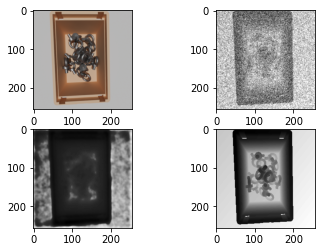

In [15]:
#Test model and save predicted images
cwd = os.getcwd()## to get the absolut path

for file_name in glob.glob(r"C:/Users/49162/Desktop/python/trainresult/U*"):
    model = torch.load(file_name)['model']
    img,  y_pred, y_true = test_unet(model, 20, device=torch.device("cpu"))
    rgb, bad, pred, true = convert_to_image(y_pred, y_true, img)
    directory = os.path.join(cwd,'C:/Users/49162/Desktop/python/trainresult/Predicted_Images_unet_{}'.format(file_name[-23:-3]))
    if not os.path.exists(directory):
        os.mkdir(directory)
    save_trained_images(rgb, bad, pred, true, directory+"/")

In [16]:
##because when we run the multiunet, we use two inputs and two unets, so the memory of gpu is not enough
# Train two MultiInput Net , one with best parameters and one with self choosen parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root = r"C:/Users/49162/Desktop/python/images/"
camera_dir = r"camera/"
sensor_dir = r"depth_bad/"
masks_dir = r"depth_real/"

train_size = 0.8
test_size = 0.1
val_size = 0.1

data_set_mi = MI_Dataset(root, camera_dir, sensor_dir, masks_dir) 


train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)
    

unet_models = []

for config in mi_configs:
    train_loader = DataLoader(data_set_mi, batch_size = config['batch_size'], sampler=train_sampler, drop_last=True)
    val_loader = DataLoader(data_set_mi, batch_size = config['batch_size'], sampler=val_sampler, drop_last=True)
    
    #Model
    model = MultiInput_UNET(in_features  = 3, 
                    out_features = 1, 
                    batch_size   = config['batch_size'],
                    kernel       = config['kernel'],
                    activation   = getattr(torch, config['activation']),
                    dropout_rate = config['dropout_rate'])
    
    #Optimizer and Criterions
    optimizer = optim.Adam(model.parameters(), lr= config['learning_rate'])
    criterion = torch.nn.MSELoss()
    
    #Set to GPU
    model = model.to(device)
    criterion = criterion.to(device)
    
    #Start Evaluating
    val_loss = 0.0
    ret_val = 0.0
    epochs = 25
    
    min_val_loss = 20.0
    epoch_losses = []
    val_losses = []
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        print("Starting Epoch [{}/{}]".format(epoch+1, epochs))
        
        #Train
        epoch_loss = train_HPO_mi(model, train_loader, criterion, optimizer, device)
        epoch_losses.append(epoch_loss)
        
        #Val
        val_loss = val_HPO_mi(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        #early_stopping
        if val_loss < min_val_loss: 
            epochs_no_improve = 0
            min_val_loss = val_loss
        else:
            epochs_no_improve += 1
        #print("after: ", min_val_loss, eval_loss, epochs_no_improve)
        if epochs_no_improve > 5:
            print("Early stopping")
            early_stop = True
            break
        
        print("Validation loss: {}".format(round(val_loss,6)))
    
    #save model
    unet_models.append(model)
    torch.save({'model':model,
                'model_state_dict':model.state_dict(),
                'epoch_losses':epoch_losses,
                'val_losses':val_losses
               }, r'C:/Users/49162/Desktop/python/trainresult/MultiInput_bs{}_dr{:{width1}.{prec1}f}_lr{:{width2}.{prec2}f}.pt'.format(config['batch_size'],config['dropout_rate'],config['learning_rate'] ,width1 = 7, prec1 = 5, width2=7, prec2=5))
      # the save path trained nns multiinput_dr

Starting Epoch [1/20]
Validation loss: 0.001472
Starting Epoch [2/20]
Validation loss: 0.001024
Starting Epoch [3/20]
Validation loss: 0.000814
Starting Epoch [4/20]
Validation loss: 0.000771
Starting Epoch [5/20]
Validation loss: 0.00061
Starting Epoch [6/20]
Validation loss: 0.000535
Starting Epoch [7/20]
Validation loss: 0.000506
Starting Epoch [8/20]
Validation loss: 0.000452
Starting Epoch [9/20]
Validation loss: 0.000422
Starting Epoch [10/20]
Validation loss: 0.000445
Starting Epoch [11/20]
Validation loss: 0.000464
Starting Epoch [12/20]
Validation loss: 0.00036
Starting Epoch [13/20]
Validation loss: 0.000376
Starting Epoch [14/20]
Validation loss: 0.000329
Starting Epoch [15/20]
Validation loss: 0.000357
Starting Epoch [16/20]
Validation loss: 0.000305
Starting Epoch [17/20]
Validation loss: 0.0003
Starting Epoch [18/20]
Validation loss: 0.000282
Starting Epoch [19/20]
Validation loss: 0.000261
Starting Epoch [20/20]
Validation loss: 0.000256
Starting Epoch [1/20]


RuntimeError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 6.00 GiB total capacity; 3.53 GiB already allocated; 0 bytes free; 3.88 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

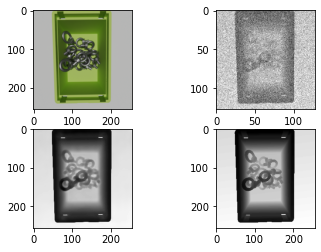

In [17]:
#Test model and save predicted images
cwd = os.getcwd()

for file_name in glob.glob(r"C:/Users/49162/Desktop/python/trainresult/Multi*"):# find file name with multi
    model = torch.load(file_name)['model'] # import neural networks
    img, y_bad, y_pred, y_true = test_mi(model, 20, device=torch.device("cpu")) # test mi unet
    rgb, bad, pred, true = convert_to_image(y_pred, y_true, img, y_bad) # show it as image
    directory = os.path.join(cwd,'C:/Users/49162/Desktop/python/trainresult/Predicted_Images_MultiInput_{}'.format(file_name[-26:-3])) # to save the image its the directory
    if not os.path.exists(directory):
        os.mkdir(directory)
    else:
        print("directroy already exists")
    save_trained_images(rgb, bad, pred, true, directory+"/")


In [18]:
## save img_rgb,img_depth_bad,img_depth_pred,img_depth_true
def save_images(rgb, y_bad, y_pred, y_true, directory):
    """saves images"""
    
    print(rgb[0].shape)
    plt.imshow(rgb[0][:,:,:])
    plt.savefig(directory + 'img_rgb.png')    
    plt.imshow(y_bad[0][:,:],'gray')
    plt.savefig(directory + 'img_depth_bad.png')    
    plt.imshow(y_pred[0][:,:],'gray')
    plt.savefig(directory + 'img_depth_pred.png')    
    plt.imshow(y_true[0][:,:],'gray')
    plt.savefig(directory + 'img_depth_true.png')    
    

In [19]:
##to comcatenate the depth_image and rgb_image
def __merged_data(self, dirs, modes=["RGB"]):
    
    #Check modes , check the mode of the same file, the same file must have only one mode and the typ of mode only be 2
    if len(modes) == 1:
        modes = len(dirs) * modes
    elif len(modes) != len(dirs):
        raise ValueError("The number of modes must be 1 or the same number as number of directories. Transmitted modes: {}".format(len(modes)))
    elif len(modes) > 2 or len(dirs) > 2:
        raise ValueError("Not implemented number of modes or dirs")

    #Get all Values
    data = []
    for directory, mode in zip(dirs, modes):
        imgs = self.__getImages(directory, mode, as_matrix=True)
        data.append(imgs)

    #Concatenate Values
    result = []
    for date0, date1 in zip(data[0], data[1]): #If there are more than 2 values zipping. Readjust
        date1 = np.array(Image.fromarray(date1).resize((256,256),0)).reshape(256,256,1) #resize image to 256x256 pixels
        result.append(np.concatenate((date0, date1), axis = 2))
    result = np.array(result)
    result = result.transpose((0,3,1,2))

    return result

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


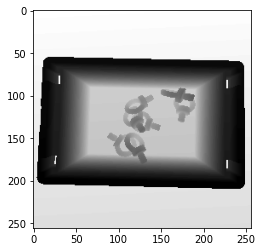

In [20]:
# plot images for Presentation

cwd = os.getcwd()# find a current working directionary
device=torch.device("cpu")

img = np.array(Image.open(r"C:/Users/49162/Desktop/python/Images_for_presentation/CameraImage_01.png").convert("RGB"))#camera rgb图片
depth_true = np.array(Image.open(r"C:/Users/49162/Desktop/python/Images_for_presentation/DepthImagereal_01.png").convert("L"))#depth 图片
depth_bad_1 = np.array(Image.open(r"C:/Users/49162/Desktop/python/Images_for_presentation/DepthImage_01.png").convert("L"))#不同的加噪效果
depth_bad_2 = np.array(Image.open(r"C:/Users/49162/Desktop/python/Images_for_presentation/DepthImage_02.png").convert("L"))
depth_bad_3 = np.array(Image.open(r"C:/Users/49162/Desktop/python/Images_for_presentation/DepthImage_03.png").convert("L"))


img_unet_1 = np.concatenate((img, np.array(Image.fromarray(depth_bad_1).resize((256,256),0)).reshape(256,256,1)), axis = 2).reshape(256,256,4,1).transpose(3,2,0,1)/255
img_unet_2 = np.concatenate((img, np.array(Image.fromarray(depth_bad_2).resize((256,256),0)).reshape(256,256,1)), axis = 2).reshape(256,256,4,1).transpose(3,2,0,1)/255
img_unet_3 = np.concatenate((img, np.array(Image.fromarray(depth_bad_3).resize((256,256),0)).reshape(256,256,1)), axis = 2).reshape(256,256,4,1).transpose(3,2,0,1)/255

y_true = depth_true.reshape(256,256,1,1).transpose(3,2,0,1)/255
img_mi = img.reshape(256,256,3,1).transpose(3,2,0,1)/255

depth_bad_1 = np.array(Image.open(r"C:/Users/49162/Desktop/python/Images_for_presentation/DepthImage_01.png").convert("RGB"))#因为是mi 所以这里是rgb 和imgmi对应
depth_bad_2 = np.array(Image.open(r"C:/Users/49162/Desktop/python/Images_for_presentation/DepthImage_02.png").convert("RGB"))
depth_bad_3 = np.array(Image.open(r"C:/Users/49162/Desktop/python/Images_for_presentation/DepthImage_03.png").convert("RGB"))


y_bad_1_mi = depth_bad_1.reshape(128,128,3,1).transpose(3,2,0,1)/255
y_bad_2_mi = depth_bad_2.reshape(128,128,3,1).transpose(3,2,0,1)/255
y_bad_3_mi = depth_bad_3.reshape(128,128,3,1).transpose(3,2,0,1)/255


img_unet_1 = torch.from_numpy(img_unet_1)
img_unet_2 = torch.from_numpy(img_unet_2)
img_unet_3 = torch.from_numpy(img_unet_3)
y_true = torch.from_numpy(y_true)

img_mi = torch.from_numpy(img_mi)
y_bad_1_mi = torch.from_numpy(y_bad_1_mi)
y_bad_2_mi = torch.from_numpy(y_bad_2_mi)
y_bad_3_mi = torch.from_numpy(y_bad_3_mi)


    
for file_name in glob.glob(r"C:/Users/49162/Desktop/python/trainresult/U*"):
    model = torch.load(file_name)['model']
    test_loader = DataLoader(data_set_unet, batch_size = 1, sampler=test_sampler, drop_last=True)
    
    directory = os.path.join(cwd,'C:/Users/49162/Desktop/python/trainresult/Predicted_Images_unet_forPresentation_{}'.format(file_name[-24:-3]))
    if not os.path.exists(directory):
        os.mkdir(directory)
    else:
        print("directroy already exists")
    
    

    image,  y_true = img_unet_1.to(device), y_true.to(device)
    model.to(device)
    y_pred= (model(image.float()))
    rgb, bad, pred, true = convert_to_image([y_pred], [y_true], [img_unet_1])
    directory = os.path.join(cwd,'C:/Users/49162/Desktop/python/trainresult/Predicted_Images_unet_forPresentation_{}/var_1'.format(file_name[-24:-3]))
    if not os.path.exists(directory):
        os.mkdir(directory)
    else:
        print("directroy already exists")
    save_images(rgb, bad, pred, true, directory+"/")
    
    image,  y_true = img_unet_2.to(device), y_true.to(device)
    model.to(device)
    y_pred= model(image.float())
    rgb, bad, pred, true = convert_to_image([y_pred], [y_true], [img_unet_2])
    directory = os.path.join(cwd,'C:/Users/49162/Desktop/python/trainresult/Predicted_Images_unet_forPresentation_{}/var_2'.format(file_name[-24:-3]))
    if not os.path.exists(directory):
        os.mkdir(directory)
    else:
        print("directroy already exists")
    save_images(rgb, bad, pred, true, directory+"/")
    
    image,  y_true = img_unet_3.to(device), y_true.to(device)
    model.to(device)
    y_pred= model(image.float())
    rgb, bad, pred, true = convert_to_image([y_pred], [y_true], [img_unet_3])
    directory = os.path.join(cwd,'C:/Users/49162/Desktop/python/trainresult/Predicted_Images_unet_forPresentation_{}/var_3'.format(file_name[-24:-3]))
    if not os.path.exists(directory):
        os.mkdir(directory)
    else:
        print("directroy already exists")
    save_images(rgb, bad, pred, true, directory+"/")
    
    
    
for file_name in glob.glob(r"C:/Users/49162/Desktop/python/trainresult/Multi*"):
    model = torch.load(file_name)['model']
    
    directory = os.path.join(cwd,'C:/Users/49162/Desktop/python/trainresult/Predicted_Images_mi_forPresentation_{}'.format(file_name[-24:-3]))
    if not os.path.exists(directory):
        os.mkdir(directory)
    else:
        print("directroy already exists")
    
    img, y_bad,  y_true = img_mi.to(device), y_bad_1_mi.to(device), y_true.to(device)
    model.to(device)
    y_pred= model(img.float(), y_bad.float())
    rgb, bad, pred, true = convert_to_image([y_pred], [y_true], [img], [y_bad])
    directory = os.path.join(cwd,'C:/Users/49162/Desktop/python/trainresult/Predicted_Images_mi_forPresentation_{}/var_1'.format(file_name[-24:-3]))
    if not os.path.exists(directory):
        os.mkdir(directory)
    else:
        print("directroy already exists")
    save_images(rgb, bad, pred, true, directory+"/")   
    
    img, y_bad,  y_true = img_mi.to(device), y_bad_2_mi.to(device), y_true.to(device)
    model.to(device)
    y_pred= model(img.float(), y_bad.float())
    rgb, bad, pred, true = convert_to_image([y_pred], [y_true], [img], [y_bad])
    directory = os.path.join(cwd,'C:/Users/49162/Desktop/python/trainresult/Predicted_Images_mi_forPresentation_{}/var_2'.format(file_name[-24:-3]))
    if not os.path.exists(directory):
        os.mkdir(directory)
    else:
        print("directroy already exists")
    save_images(rgb, bad, pred, true, directory+"/")   
    
    img, y_bad,  y_true = img_mi.to(device), y_bad_3_mi.to(device), y_true.to(device)
    model.to(device)
    y_pred= model(img.float(), y_bad.float())
    rgb, bad, pred, true = convert_to_image([y_pred], [y_true], [img], [y_bad])
    directory = os.path.join(cwd,'C:/Users/49162/Desktop/python/trainresult/Predicted_Images_mi_forPresentation_{}/var_3'.format(file_name[-24:-3]))
    if not os.path.exists(directory):
        os.mkdir(directory)
    else:
        print("directroy already exists")
    save_images(rgb, bad, pred, true, directory+"/")   

In [28]:
#plot epoch loss, val loss and save figures
import matplotlib.patches as mpatches

cwd = os.getcwd()
i=1
for file_name in glob.glob(r"C:/Users/49162/Desktop/python/trainresult/Multi*"):
    val_loss = torch.load(file_name)['val_losses']#前面提到过 val losses
    epoch_loss = torch.load(file_name)['epoch_losses']
    numb_epochs = len(val_loss)
    
    plt.plot(np.arange(numb_epochs),val_loss, label='validation loss')
    plt.plot(np.arange(numb_epochs),epoch_loss, label='epoch loss')
    plt.ylim(top=0.002)
    plt.ylim(bottom=0.00)

    #red_patch = mpatches.Patch(color='red', label='val_loss')
    #blue_patch = mpatches.Patch(color='blue', label='epoch_loss')
       
    plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)

    plt.savefig(cwd+'/trained_NNs/Losses/Losses_mi_{}.png'.format(i))
    i+=1
    plt.clf()
    
for file_name in glob.glob(r"C:/Users/49162/Desktop/python/trainresult/U*"):
    val_loss = torch.load(file_name)['val_losses']
    epoch_loss = torch.load(file_name)['epoch_losses']
    numb_epochs = len(val_loss)
    
    plt.plot(np.arange(numb_epochs),val_loss, label='validation loss')
    plt.plot(np.arange(numb_epochs),epoch_loss, label='epoch loss')
    plt.ylim(top=0.002)
    plt.ylim(bottom=0.00)
    #red_patch = mpatches.Patch(color='red', label='val_loss')
    #blue_patch = mpatches.Patch(color='blue', label='epoch_loss')
       
    plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)

    plt.savefig(cwd+'/trainresult/Losses/Losses_unet_{}.png'.format(i))
    i+=1
    plt.clf()

<Figure size 432x288 with 0 Axes>